In [1]:
import pandas as pd

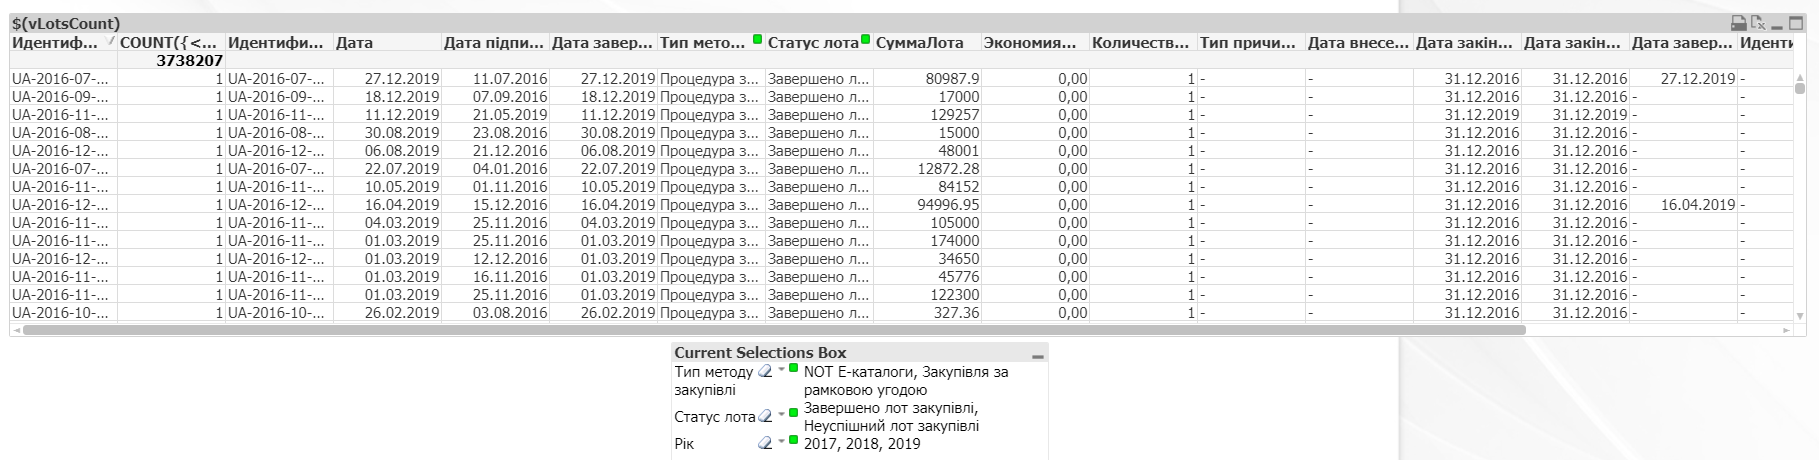

In [2]:
data = pd.read_csv("Prozorro_Efficiency_v1_13.02.2020.csv", sep=";", dtype="str")
data.drop(columns='COUNT({<$1>} Distinct IDLot)', inplace=True)
data.drop(index=0, inplace=True)

# Formatting the data
data["Дата"] = pd.to_datetime(data["Дата"], format="%d.%m.%Y")
data["Дата підписання договору"] = pd.to_datetime(data["Дата підписання договору"], format="%d.%m.%Y", errors='coerce')
data["Дата закінчення дії договору (згідно тендера)"] = pd.to_datetime(data["Дата закінчення дії договору (згідно тендера)"], format="%d.%m.%Y", errors='coerce')
data["Дата закінчення дії договору (згідно договору)"] = pd.to_datetime(data["Дата закінчення дії договору (згідно договору)"], format="%d.%m.%Y", errors='coerce')
data["Дата завершення договору"] = pd.to_datetime(data["Дата завершення договору"], format="%d.%m.%Y", errors='coerce')
data["СуммаЛота"] = data["СуммаЛота"].str.replace(",", ".").astype(float)
data["ЭкономияЛота"] = data["ЭкономияЛота"].str.replace(",", ".").astype(float)
data["КоличествоУчастниковЛота"] = data["КоличествоУчастниковЛота"].str.replace(",", ".").astype(int)

# Additional variables
data["competitive"] = data["Тип методу закупівлі"].isin(['Відкриті торги', 'Відкриті торги із публікацією англ. мовою',
                                                         'Допорогова закупівля',
                                                         'Переговорна процедура (для потреб оборони)']).astype(int)
data["claim_or_compl"] = (data["ИдентификаторЖалобыТендера"]!="-").astype(int)
data["addendum"] = (data["Дата внесення змін до договору"]!="-").astype(int)
data["year"] = data["Дата"].dt.year
data["lot_sav_share"] = data["ЭкономияЛота"] / data["СуммаЛота"]

print("The shape of the DF: ", data.shape)
data.head(3)

The shape of the DF:  (4287025, 23)


,Идентификатор,ИдентификаторЛота,Дата,Дата підписання договору,Дата завершения,Тип методу закупівлі,Статус лота,СуммаЛота,ЭкономияЛота,КоличествоУчастниковЛота,...,Дата закінчення дії договору (згідно договору),Дата завершення договору,ИдентификаторЖалобыТендера,Тип скарги тендера,Статус скарги,competitive,claim_or_compl,addendum,year,lot_sav_share
1,UA-2016-07-11-000419-b,UA-2016-07-11-000419-b-L1,2019-12-27,2016-07-11,27.12.2019,Процедура звітування про укладений договір,Завершено лот закупівлі,80987.9,0.0,1,...,2016-12-31,2019-12-27,-,-,-,0,0,0,2019,0.0
2,UA-2016-09-13-000354-a,UA-2016-09-13-000354-a-L1,2019-12-18,2016-09-07,18.12.2019,Процедура звітування про укладений договір,Завершено лот закупівлі,17000.0,0.0,1,...,2016-12-31,NaT,-,-,-,0,0,0,2019,0.0
3,UA-2016-11-10-001404-b,UA-2016-11-10-001404-b-L1,2019-12-11,2019-05-21,11.12.2019,Процедура звітування про укладений договір,Завершено лот закупівлі,129257.0,0.0,1,...,2019-12-31,NaT,-,-,-,0,0,0,2019,0.0


# Calculation

## Досягнули економії коштів

Загальна економія в конкурентних процедурах

In [3]:
df_sav_rate = data[['ИдентификаторЛота', 'СуммаЛота', 'ЭкономияЛота', "year"]][(data["Статус лота"]=="Завершено лот закупівлі") & 
                                                                               (data["competitive"]==1)].drop_duplicates()
df_sav_rate_res = pd.DataFrame(df_sav_rate.groupby(df_sav_rate["year"]).sum())
df_sav_rate_res["sav_rate_gross"] = df_sav_rate_res["ЭкономияЛота"] / df_sav_rate_res["СуммаЛота"]

df_sav_rate_res

,СуммаЛота,ЭкономияЛота,sav_rate_gross
year,,,
2017,3.534356e+11,2.751843e+10,0.077860
2018,4.492160e+11,3.098128e+10,0.068967
2019,3.427010e+11,2.954803e+10,0.086221


## Договір виконаний в строк

Частка лотів, в якийх дата завершення договору з тендера не перевищує фактичної дату завершення договору

In [4]:
df_contract_delay = data[['ИдентификаторЛота', "Тип методу закупівлі", 
                          'Дата закінчення дії договору (згідно тендера)', 'Дата закінчення дії договору (згідно договору)', 
                          "year"]][(data["Статус лота"]=="Завершено лот закупівлі") & 
                                   ~(data["Тип методу закупівлі"].isin(["Допорогова закупівля", 
                                                                        "Процедура звітування про укладений договір"]))].drop_duplicates()
df_contract_delay["df_contract_delay_days"] = df_contract_delay['Дата закінчення дії договору (згідно договору)'] - df_contract_delay['Дата закінчення дії договору (згідно тендера)']
df_contract_delay["df_contract_delay_dummy"] = (df_contract_delay["df_contract_delay_days"]>="15 days").astype(int)

df_contract_delay_res = df_contract_delay.pivot_table(values="ИдентификаторЛота", index="year", columns="df_contract_delay_dummy", aggfunc="count")
df_contract_delay_res["sum"] = df_contract_delay_res.sum(axis=1)
df_contract_delay_res["non_contract_delay_share"] = df_contract_delay_res[0] / df_contract_delay_res["sum"]
df_contract_delay_res


df_contract_delay_dummy,0,1,sum,non_contract_delay_share
year,,,,
2017,123705,14264,137969,0.896614
2018,146652,18925,165577,0.885703
2019,151365,20703,172068,0.879681


## Закупівля відбулась

Частка завершених процедур

In [5]:
df_succ = data[['ИдентификаторЛота', "Статус лота", "year"]][(data["competitive"]==1)].drop_duplicates()

df_succ_res = df_succ.pivot_table(values="ИдентификаторЛота", index="year", columns="Статус лота", aggfunc="count")
df_succ_res["sum"] = df_succ_res.sum(axis=1)
df_succ_res["succ_share"] = df_succ_res["Завершено лот закупівлі"] / df_succ_res["sum"]

df_succ_res

Статус лота,Завершено лот закупівлі,Неуспішний лот закупівлі,sum,succ_share
year,,,,
2017,277099,155402,432501,0.640690
2018,270806,167543,438349,0.617786
2019,244616,126975,371591,0.658294


## Закупівля відбулась з використанням конкурентної процедури

Частка конкурентних завершених процедур

In [6]:
df_compet_proc = data[['ИдентификаторЛота', 'competitive', "year"]][(data["Статус лота"]=="Завершено лот закупівлі")].drop_duplicates()

df_compet_proc_res = df_compet_proc.pivot_table(values="ИдентификаторЛота", index="year", columns="competitive", aggfunc="count")
df_compet_proc_res["sum"] = df_compet_proc_res.sum(axis=1)
df_compet_proc_res["compet_share"] = df_compet_proc_res[1] / df_compet_proc_res["sum"]

df_compet_proc_res

competitive,0,1,sum,compet_share
year,,,,
2017,627434,277099,904533,0.306345
2018,845241,270806,1116047,0.242647
2019,1023070,244616,1267686,0.192963


## Закупівля була проведена в заплановані терміни

Частка конкурентних лотів, які були проведені без відхилення від орієнтовного терміну проведення

In [7]:
df_period = data[['ИдентификаторЛота', "Тип методу закупівлі", 
                  'Дата', 'Дата підписання договору', "year"]][(data["Статус лота"]=="Завершено лот закупівлі") & 
                                                               (data["competitive"]==1)].drop_duplicates()
df_period["procedure_duration_fact_bd"] = np.busday_count(df_period['Дата'].values.astype('datetime64[D]'), df_period['Дата підписання договору'].values.astype('datetime64[D]'))
df_period["procedure_duration_required"] = df_period["Тип методу закупівлі"].map({'Допорогова закупівля': 35,
                                                                                  'Відкриті торги': 30,
                                                                                  'Відкриті торги із публікацією англ. мовою': 67,
                                                                                  'Переговорна процедура (для потреб оборони)': 21})
df_period["duration_delay"] = ((df_period["procedure_duration_fact_bd"] - df_period["procedure_duration_required"])>0).astype(int)

df_period_res = df_period.pivot_table(values="ИдентификаторЛота", index="year", columns="duration_delay", aggfunc="count")
df_period_res["sum"] = df_period_res.sum(axis=1)
df_period_res["non_delay_share"] = df_period_res[0] / df_period_res["sum"]
df_period_res

duration_delay,0,1,sum,non_delay_share
year,,,,
2017,243516,33583,277099,0.878805
2018,235370,35436,270806,0.869146
2019,213031,31585,244616,0.870879


In [8]:
df_period["procedure_duration_fact_bd"].groupby(df_period["Тип методу закупівлі"]).median()

Тип методу закупівлі
Відкриті торги                                27
Відкриті торги із публікацією англ. мовою     48
Допорогова закупівля                          13
Переговорна процедура (для потреб оборони)    23
Name: procedure_duration_fact_bd, dtype: int64

## Закупівля була проведена відповідно до плану

Частка лотів, які були оголошені в заплановані терміни

## Не змінювалась ціна після підписання договору (не було додаткових угод)

Частка лотів, в яких не було додаткових угод

In [9]:
data["Тип методу закупівлі"].unique()

array(['Процедура звітування про укладений договір',
       'Переговорна процедура',
       'Переговорна процедура за нагальною потребою',
       'Допорогова закупівля', 'Відкриті торги',
       'Відкриті торги із публікацією англ. мовою',
       'Переговорна процедура (для потреб оборони)'], dtype=object)

In [10]:
df_addendum = data[['ИдентификаторЛота', "Тип методу закупівлі", 'addendum', 
                    "year"]][(data["Статус лота"]=="Завершено лот закупівлі") & 
                             (data["Тип методу закупівлі"].isin(['Відкриті торги', 'Відкриті торги із публікацією англ. мовою',
                                                                 'Переговорна процедура','Переговорна процедура за нагальною потребою',
                                                                  "Переговорна процедура (для потреб оборони)"]))].drop_duplicates()

df_addendum_res = df_addendum.pivot_table(values="ИдентификаторЛота", index="year", columns="addendum", aggfunc="count")
df_addendum_res["sum"] = df_addendum_res.sum(axis=1)
df_addendum_res["addendum_share"] = df_addendum_res[1] / df_addendum_res["sum"]
df_addendum_res["without_addendum_share"] = df_addendum_res[0] / df_addendum_res["sum"]

df_addendum_res

addendum,0,1,sum,addendum_share,without_addendum_share
year,,,,,
2017,69790,68179,137969,0.494162,0.505838
2018,79433,86144,165577,0.520265,0.479735
2019,87133,84935,172068,0.493613,0.506387


## Не отримували скарг чи вимог від учасників

Частка конкурентних процедур без скарг чи вимог

In [11]:
df_compl = data[['ИдентификаторЛота', 
                 'claim_or_compl', 
                 "year"]][(((data["Тип методу закупівлі"].isin(["Допорогова закупівля", "Переговорна процедура (для потреб оборони)"])) & (data["КоличествоУчастниковЛота"]>=1)) | 
                           ((data["Тип методу закупівлі"].isin(['Відкриті торги', 'Відкриті торги із публікацією англ. мовою'])) & (data["КоличествоУчастниковЛота"]>=2))) & 
                          (data["competitive"]==1)].drop_duplicates()

df_compl_res = df_compl.pivot_table(values="ИдентификаторЛота", index="year", columns="claim_or_compl", aggfunc="count")
df_compl_res["sum"] = df_compl_res.sum(axis=1)
df_compl_res["claim_or_compl_share"] = df_compl_res[1] / df_compl_res["sum"]
df_compl_res["without_claim_or_compl_share"] = df_compl_res[0] / df_compl_res["sum"]

df_compl_res

claim_or_compl,0,1,sum,claim_or_compl_share,without_claim_or_compl_share
year,,,,,
2017,279587,24198,303785,0.079655,0.920345
2018,271298,26039,297337,0.087574,0.912426
2019,238001,30433,268434,0.113372,0.886628


## Досягнули високого рівня конкуренції

Середня кількість учасників в конкурентних процедурах

In [12]:
df_compet = data[['ИдентификаторЛота', 'КоличествоУчастниковЛота', "year"]][(data["Статус лота"]=="Завершено лот закупівлі") & 
                                                                               (data["competitive"]==1)].drop_duplicates()
df_compet_res = pd.DataFrame(df_compet["КоличествоУчастниковЛота"].groupby(df_compet["year"]).mean())
df_compet_res.columns = ["num_part_aver"]

df_compet_res

,num_part_aver
year,
2017,2.283960
2018,2.291423
2019,2.393772


# Final results

In [13]:
df_index_source = pd.concat([df_sav_rate_res["sav_rate_gross"], df_contract_delay_res["non_contract_delay_share"], 
                             df_succ_res["succ_share"], df_period_res["non_delay_share"], 
                             df_addendum_res["without_addendum_share"], df_compl_res["without_claim_or_compl_share"], 
                             df_compet_proc_res["compet_share"], df_compet_res["num_part_aver"]], 
                            axis=1)

df_index_source.to_excel("df_index_source.xlsx")

df_index_source

,sav_rate_gross,non_contract_delay_share,succ_share,non_delay_share,without_addendum_share,without_claim_or_compl_share,compet_share,num_part_aver
year,,,,,,,,
2017,0.077860,0.896614,0.640690,0.878805,0.505838,0.920345,0.306345,2.283960
2018,0.068967,0.885703,0.617786,0.869146,0.479735,0.912426,0.242647,2.291423
2019,0.086221,0.879681,0.658294,0.870879,0.506387,0.886628,0.192963,2.393772
